In [1]:
from src.datamodules.sr_datamodule import *
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np

In [2]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 16))
    for i, img in enumerate(imgs):
        img = img.detach()
        print(img.min(), img.max())
        img = F.to_pil_image(img)
        print(np.asarray(img).min(), np.asarray(img).max())
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
dm = SRDataModule(batch_size=1)
dm.prepare_data()
dm.setup()

In [4]:
dm.hparams.trainsets

[('DIV2K', 'train')]

In [5]:
dm.hparams.testsets

[('DIV2K', 'train'),
 ('benchmark', 'B100'),
 ('benchmark', 'Set5'),
 ('benchmark', 'Set14'),
 ('benchmark', 'Urban100')]

In [6]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loaders = dm.test_dataloader()

C:\Users\329176\.conda\envs\clat\lib\site-packages\torch\utils\data\dataloader.py:487: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print([len(test_loader.dataset) for test_loader in test_loaders])

16000
100
[100, 100, 5, 14, 100]


torch.Size([1, 3, 192, 192]) tensor(0.) tensor(1.)
torch.Size([1, 3, 384, 384]) tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
0 255
tensor(0.) tensor(1.)
0 255
torch.Size([1, 3, 192, 192]) tensor(0.0431) tensor(1.)
torch.Size([1, 3, 576, 576]) tensor(0.0588) tensor(1.)
tensor(0.0431) tensor(1.)
11 255
tensor(0.0588) tensor(1.)
15 255
torch.Size([1, 3, 192, 192]) tensor(0.0549) tensor(1.)
torch.Size([1, 3, 768, 768]) tensor(0.) tensor(1.)
tensor(0.0549) tensor(1.)
14 255
tensor(0.) tensor(1.)
0 255


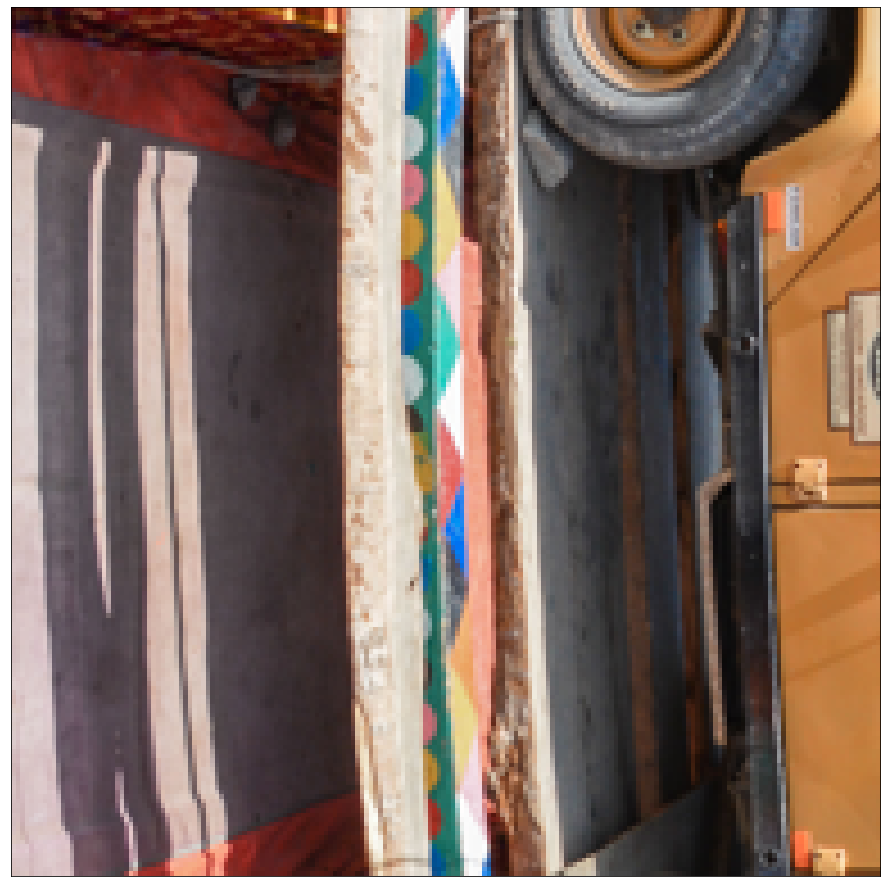

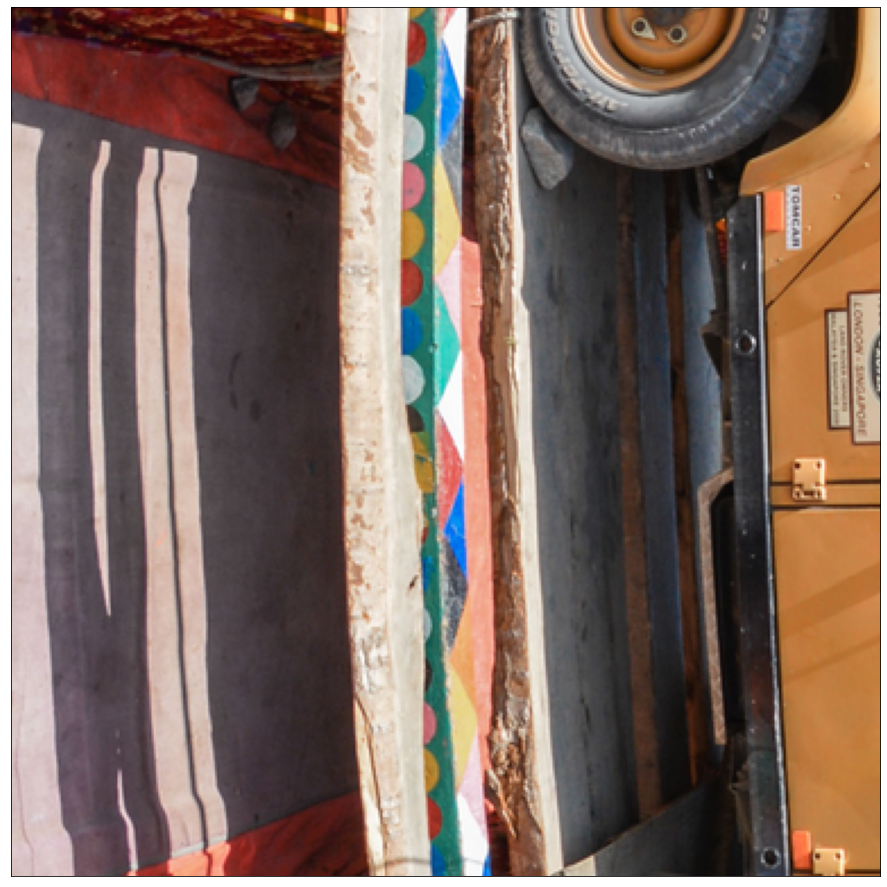

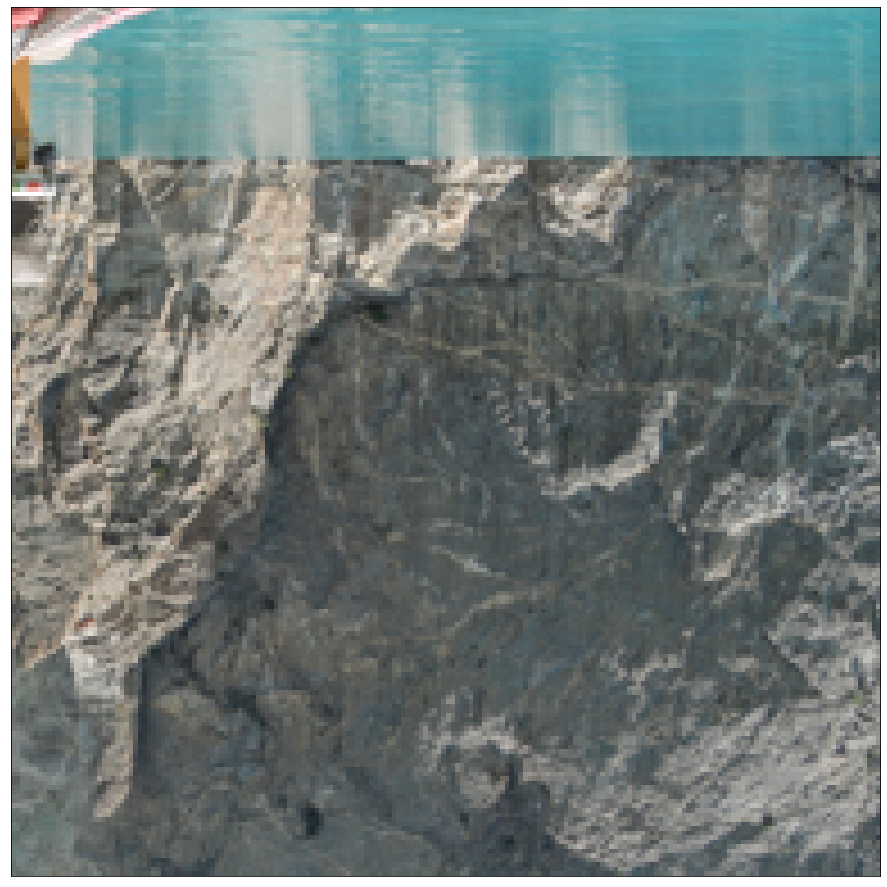

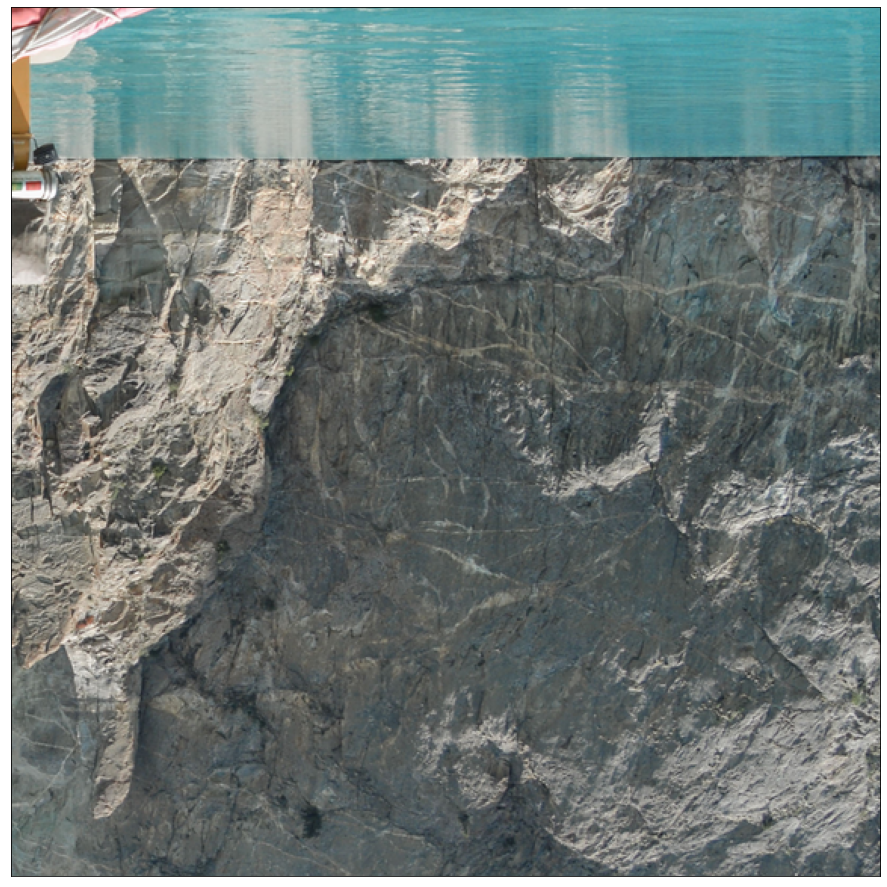

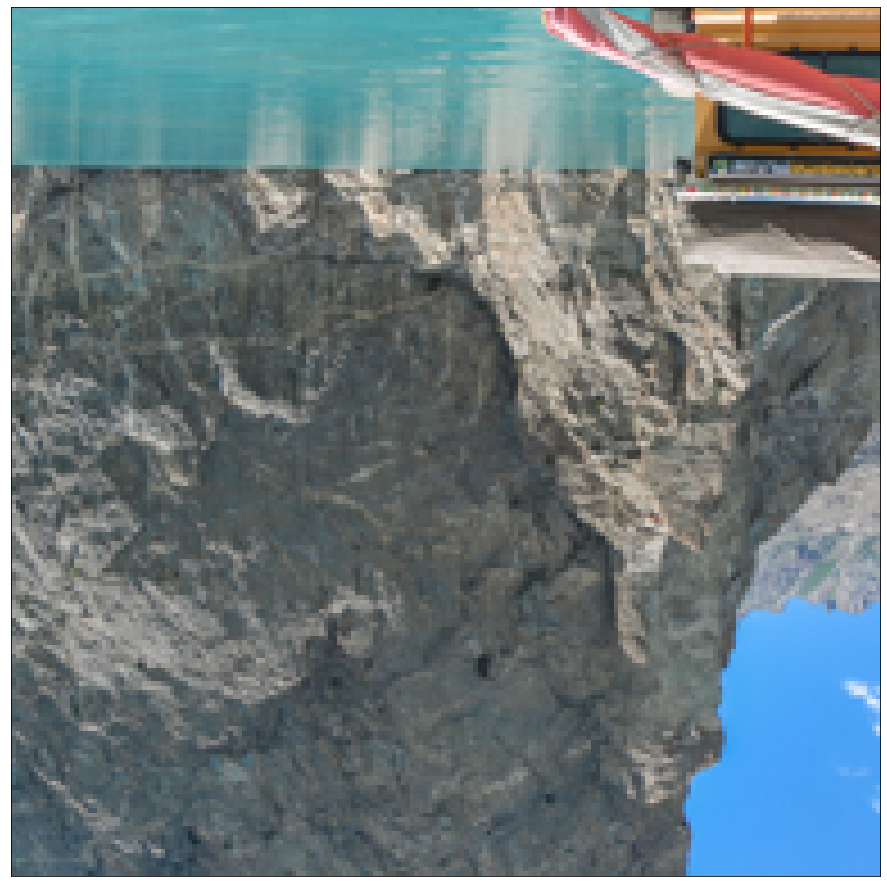

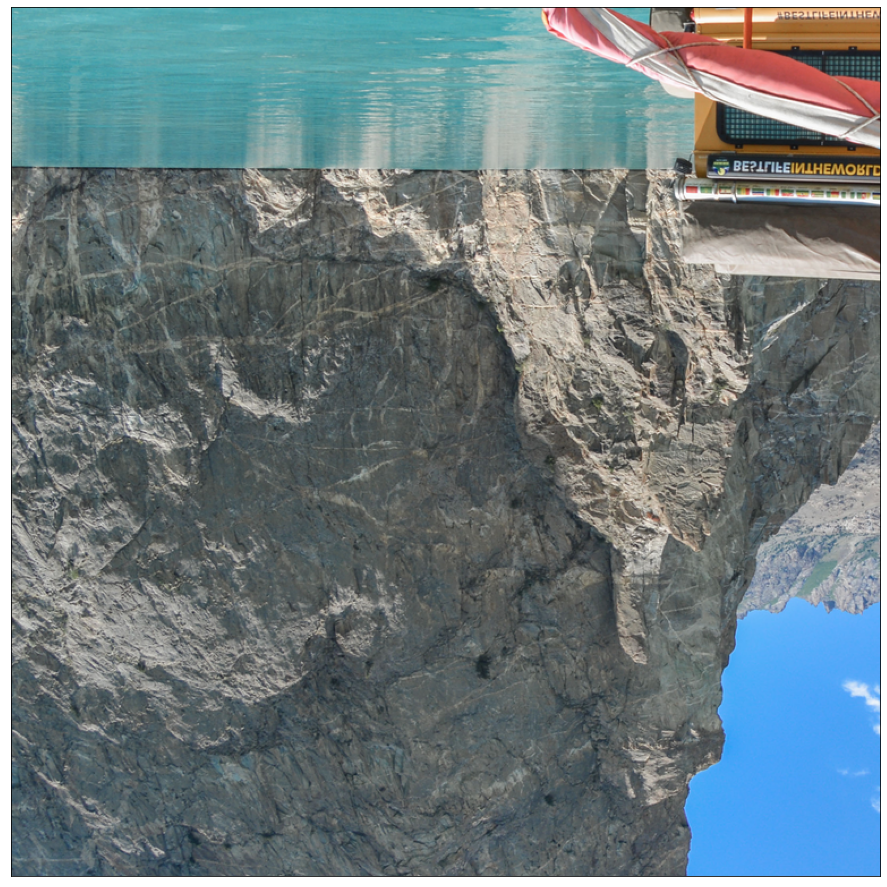

In [8]:
batch = next(iter(train_loader))
for scale in batch:
    lr, hr, _ = batch[scale]
    print(lr.shape, lr.min(), lr.max())
    print(hr.shape, hr.min(), hr.max())
    show(make_grid(lr))
    show(make_grid(hr))

In [26]:
for test_loader in test_loaders:
    batch = next(iter(test_loader))
    #show(make_grid(batch[4][0]))
    #show(make_grid(batch[4][1]))
    for scale in batch:
        print(scale, batch[scale][0].shape, batch[scale][1].shape)

2 torch.Size([1, 3, 678, 1020]) torch.Size([1, 3, 1356, 2040])
2.5 torch.Size([1, 3, 542, 816]) torch.Size([1, 3, 1356, 2040])
3 torch.Size([1, 3, 452, 680]) torch.Size([1, 3, 1356, 2040])
3.5 torch.Size([1, 3, 387, 583]) torch.Size([1, 3, 1356, 2040])
4 torch.Size([1, 3, 339, 510]) torch.Size([1, 3, 1356, 2040])
6 torch.Size([1, 3, 226, 340]) torch.Size([1, 3, 1356, 2040])
8 torch.Size([1, 3, 170, 255]) torch.Size([1, 3, 1356, 2040])
10 torch.Size([1, 3, 136, 204]) torch.Size([1, 3, 1356, 2040])
15 torch.Size([1, 3, 90, 136]) torch.Size([1, 3, 1356, 2040])
2 torch.Size([1, 3, 240, 160]) torch.Size([1, 3, 481, 321])
2.5 torch.Size([1, 3, 192, 128]) torch.Size([1, 3, 481, 321])
3 torch.Size([1, 3, 160, 107]) torch.Size([1, 3, 481, 321])
3.5 torch.Size([1, 3, 137, 92]) torch.Size([1, 3, 481, 321])
4 torch.Size([1, 3, 120, 80]) torch.Size([1, 3, 481, 321])
6 torch.Size([1, 3, 80, 54]) torch.Size([1, 3, 481, 321])
8 torch.Size([1, 3, 60, 40]) torch.Size([1, 3, 481, 321])
10 torch.Size([1, 

In [ ]:
from src.models.components.imsisr import *
import torch

In [ ]:
net = IMSISR(mode=3, init_q=True).cuda()

In [ ]:
x = torch.rand(1,3,48,48).cuda()
y = torch.rand(1,3,64,69).cuda()
size = [64, 69]

In [ ]:
out = net(x, size)

In [ ]:
loss = (out - y).mean()
loss.backward()
for name, param in net.named_parameters():
    if param.grad is None:
        print(name)

In [ ]:
with torch.no_grad():
    for split in range(5):
        print((net(x,size,split) - net(x,size,0)).sum())

In [ ]:
data = SRData(name='benchmark',split='Set14', bin=False, patch_size=0)

In [ ]:
data[0]

In [ ]:
data.lr_dir

In [ ]:
import torch

In [ ]:
torch.cuda.memory_reserved()

In [ ]:
net = LIIF().cuda()
with torch.no_grad():
    for dataset in dm.data_test:
        for sample in dataset:
            for scale in [2,3,4]:
                net(sample[scale][0].unsqueeze(0),sample[scale][1].shape[-2:])

In [ ]:
def to_pixel_samples(inp, size, ranges=None, flatten=True):
    """ Convert the image to coord-RGB pairs.
        img: Tensor, (3, H, W)
    """
    coord_seqs = []
    for i, n in enumerate(size):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n, device=inp.device).float()
        coord_seqs.append(seq)
    hr_coord = torch.stack(torch.meshgrid(*coord_seqs, indexing='ij'), dim=-1)
    if flatten:
        hr_coord = hr_coord.view(-1, hr_coord.shape[-1])

    cell = torch.ones_like(hr_coord)
    cell[:, 0] *= 2 / size[-2]
    cell[:, 1] *= 2 / size[-1]
    print(hr_coord.shape, cell.shape)

In [ ]:
to_pixel_samples(torch.rand(16,3,48,48).cuda(), [96,96])

In [ ]:
import torch
import torch.nn.functional as F

In [ ]:
x = torch.arange(1, 1 + 1*2*5*5).view(1,2,5,5)
x

In [ ]:
unf = F.unfold(x.float(), kernel_size=3, padding=1).view(1,2,9,5,5)
var, mean = torch.var_mean(unf, dim=2, keepdim=False)
(x-mean)/torch.sqrt(var)

In [ ]:
var

In [ ]:
mean

In [ ]:
import numpy as np
from math import ceil, floor

def deriveSizeFromScale(img_shape, scale):
    output_shape = []
    for k in range(2):
        output_shape.append(int(ceil(scale[k] * img_shape[k])))
    return output_shape

def deriveScaleFromSize(img_shape_in, img_shape_out):
    scale = []
    for k in range(2):
        scale.append(1.0 * img_shape_out[k] / img_shape_in[k])
    return scale

def triangle(x):
    x = np.array(x).astype(np.float64)
    lessthanzero = np.logical_and((x>=-1),x<0)
    greaterthanzero = np.logical_and((x<=1),x>=0)
    f = np.multiply((x+1),lessthanzero) + np.multiply((1-x),greaterthanzero)
    return f

def cubic(x):
    x = np.array(x).astype(np.float64)
    absx = np.absolute(x)
    absx2 = np.multiply(absx, absx)
    absx3 = np.multiply(absx2, absx)
    f = np.multiply(1.5*absx3 - 2.5*absx2 + 1, absx <= 1) + np.multiply(-0.5*absx3 + 2.5*absx2 - 4*absx + 2, (1 < absx) & (absx <= 2))
    return f

def contributions(in_length, out_length, scale, kernel, k_width):
    if scale < 1:
        h = lambda x: scale * kernel(scale * x)
        kernel_width = 1.0 * k_width / scale
    else:
        h = kernel
        kernel_width = k_width
    x = np.arange(1, out_length+1).astype(np.float64)
    u = x / scale + 0.5 * (1 - 1 / scale)
    left = np.floor(u - kernel_width / 2)
    P = int(ceil(kernel_width)) + 2
    ind = np.expand_dims(left, axis=1) + np.arange(P) - 1 # -1 because indexing from 0
    indices = ind.astype(np.int32)
    weights = h(np.expand_dims(u, axis=1) - indices - 1) # -1 because indexing from 0
    weights = np.divide(weights, np.expand_dims(np.sum(weights, axis=1), axis=1))
    aux = np.concatenate((np.arange(in_length), np.arange(in_length - 1, -1, step=-1))).astype(np.int32)
    indices = aux[np.mod(indices, aux.size)]
    ind2store = np.nonzero(np.any(weights, axis=0))
    weights = weights[:, ind2store]
    indices = indices[:, ind2store]
    return weights, indices

def imresizemex(inimg, weights, indices, dim):
    in_shape = inimg.shape
    w_shape = weights.shape
    out_shape = list(in_shape)
    out_shape[dim] = w_shape[0]
    outimg = np.zeros(out_shape)
    if dim == 0:
        for i_img in range(in_shape[1]):
            for i_w in range(w_shape[0]):
                w = weights[i_w, :]
                ind = indices[i_w, :]
                im_slice = inimg[ind, i_img].astype(np.float64)
                outimg[i_w, i_img] = np.sum(np.multiply(np.squeeze(im_slice, axis=0), w.T), axis=0)
    elif dim == 1:
        for i_img in range(in_shape[0]):
            for i_w in range(w_shape[0]):
                w = weights[i_w, :]
                ind = indices[i_w, :]
                im_slice = inimg[i_img, ind].astype(np.float64)
                outimg[i_img, i_w] = np.sum(np.multiply(np.squeeze(im_slice, axis=0), w.T), axis=0)        
    if inimg.dtype == np.uint8:
        outimg = np.clip(outimg, 0, 255)
        return np.around(outimg).astype(np.uint8)
    else:
        return outimg

def imresizevec(inimg, weights, indices, dim):
    wshape = weights.shape
    if dim == 0:
        weights = weights.reshape((wshape[0], wshape[2], 1, 1))
        outimg =  np.sum(weights*((inimg[indices].squeeze(axis=1)).astype(np.float64)), axis=1)
    elif dim == 1:
        weights = weights.reshape((1, wshape[0], wshape[2], 1))
        outimg =  np.sum(weights*((inimg[:, indices].squeeze(axis=2)).astype(np.float64)), axis=2)
    if inimg.dtype == np.uint8:
        outimg = np.clip(outimg, 0, 255)
        return np.around(outimg).astype(np.uint8)
    else:
        return outimg

def resizeAlongDim(A, dim, weights, indices, mode="vec"):
    if mode == "org":
        out = imresizemex(A, weights, indices, dim)
    else:
        out = imresizevec(A, weights, indices, dim)
    return out

def imresize(I, scalar_scale=None, method='bicubic', output_shape=None, mode="vec"):
    if method == 'bicubic':
        kernel = cubic
    elif method == 'bilinear':
        kernel = triangle
    else:
        raise ValueError('unidentified kernel method supplied')
        
    kernel_width = 4.0
    # Fill scale and output_size
    if scalar_scale is not None and output_shape is not None:
        raise ValueError('either scalar_scale OR output_shape should be defined')
    if scalar_scale is not None:
        scalar_scale = float(scalar_scale)
        scale = [scalar_scale, scalar_scale]
        output_size = deriveSizeFromScale(I.shape, scale)
    elif output_shape is not None:
        scale = deriveScaleFromSize(I.shape, output_shape)
        output_size = list(output_shape)
    else:
        raise ValueError('either scalar_scale OR output_shape should be defined')
    scale_np = np.array(scale)
    order = np.argsort(scale_np)
    weights = []
    indices = []
    for k in range(2):
        w, ind = contributions(I.shape[k], output_size[k], scale[k], kernel, kernel_width)
        weights.append(w)
        indices.append(ind)
    B = np.copy(I) 
    flag2D = False
    if B.ndim == 2:
        B = np.expand_dims(B, axis=2)
        flag2D = True
    for k in range(2):
        dim = order[k]
        B = resizeAlongDim(B, dim, weights[dim], indices[dim], mode)
    if flag2D:
        B = np.squeeze(B, axis=2)
    return B

def convertDouble2Byte(I):
    B = np.clip(I, 0.0, 1.0)
    B = 255*B
    return np.around(B).astype(np.uint8)

In [ ]:
from torchvision.io import read_image, ImageReadMode
from pathlib import Path
from torchvision import transforms
from PIL import Image
import math

In [ ]:
#f_lr = Path(r'data\benchmark\Urban100\LR_bicubic\X4\img001x4.png')
#f_hr = Path(r'data\benchmark\Urban100\HR\img001.png')
f_hr = Path(r'data\DIV2K\DIV2K_train_HR\0014.png')
f_lr = Path(r'data\DIV2K\DIV2K_train_LR_bicubic\X4\0014x4.png')

In [ ]:
lr = read_image(str(f_lr), ImageReadMode.RGB)
hr = read_image(str(f_hr), ImageReadMode.RGB)

In [ ]:
lr.shape, hr.shape

In [ ]:
lr1 = transforms.Resize(lr.shape[-2:], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True)(hr)

In [ ]:
plt.imshow(lr1.permute(1,2,0).numpy())

In [ ]:
lr1

In [ ]:
lr.shape, test.shape

In [ ]:
(test-lr).abs().sum()

In [ ]:
test

In [ ]:
hr_down = transforms.Resize(size=lr.shape[-2:], interpolation=transforms.InterpolationMode.BICUBIC, antialias=True)(hr)

In [ ]:
hr_down = transforms.ToTensor()(
        transforms.Resize(lr.shape[-2:], Image.BICUBIC)(
            transforms.ToPILImage()(hr)))

In [ ]:
(hr_down.float()-lr.float()/255.).abs().sum()

In [ ]:
hr_down

In [ ]:
hr

In [1]:
config_path = r'C:\Users\329176\projects\sisr\logs\3_1\version_0\config.yaml'
ckpt_path = r'C:\Users\329176\projects\sisr\logs\3_1\version_0\checkpoints\last.ckpt'

In [2]:
from src.models.sr_module import SRLitModule

In [3]:
model = SRLitModule.load_from_checkpoint(ckpt_path)

In [4]:
model


SRLitModule(
  (net): IMSISR(
    (encoder): RDN(
      (SFENet1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (SFENet2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (RDBs): ModuleList(
        (0): RDB(
          (convs): Sequential(
            (0): RDB_Conv(
              (conv): Sequential(
                (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU()
              )
            )
            (1): RDB_Conv(
              (conv): Sequential(
                (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU()
              )
            )
            (2): RDB_Conv(
              (conv): Sequential(
                (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): ReLU()
              )
            )
            (3): RDB_Conv(
              (conv): Sequential(
                (0): Conv2d(2